![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:title={'center':'Sentiminetos por aerolínea'}, xlabel='airline'>

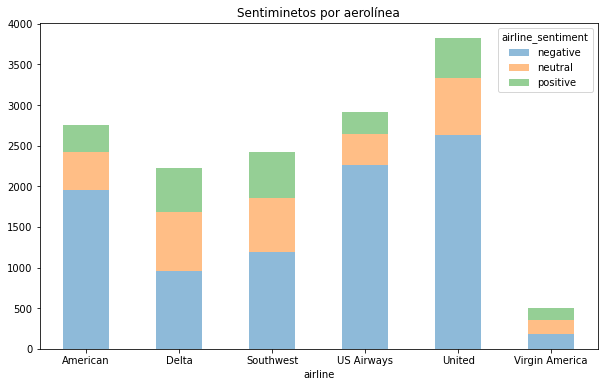

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [9]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})


In [10]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
X_train

tweet_id
569577005278064640                          @JetBlue of course I am!!✈️
569633482915209216    @AmericanAir complt incompetence on flt 295.La...
567829997668470785    @SouthwestAir Flight 4968 (N8325D) departs @MC...
569725021951791104    @USAirways does anyone from your airline know ...
567852278893416448                           @united I Want a Plane dad
                                            ...                        
569266206596734976    @SouthwestAir replacing @vitaminwater with bee...
569867943888056320    @AmericanAir at LAX and your service reps just...
569151232738095105    @SouthwestAir Been on hold for over an hour - ...
570049697924009984    @united we would...how do I contact you to dis...
569705380282019841    @JetBlue that's ok! It just sure seemed like i...
Name: text, Length: 9808, dtype: object

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [12]:
# Librería para calcular accuracy

from sklearn.metrics import accuracy_score

# Aplicacion de CountVectorizer
vect = CountVectorizer(dtype = np.int8)
x_train_vect = vect.fit_transform(X_train)
tabla_x_train_vect = x_train_vect.todense()


# Entrenamiento del modelo con hiperparámetros estándar
modelo_uno = RandomForestClassifier()
modelo_uno.fit(x_train_vect,y_train)


# Aplicar transformación en test
x_test_vect = vect.transform(X_test)


# Generar predicciones
y_pred_vect = modelo_uno.predict(x_test_vect)
y_pred_prob_vect = modelo_uno.predict_proba(x_test_vect)


# Calcular accuracy
accuracy_modelo_uno = accuracy_score(y_test, y_pred_vect)
print(accuracy_modelo_uno)


0.7729718543046358


### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [13]:
# Aplicacion de CountVectorizer eliminando stopwords
vect_sw = CountVectorizer(dtype = np.int8, stop_words= {'english'})
x_train_vect_sw = vect_sw.fit_transform(X_train)
tabla_x_train_vect_sw = x_train_vect_sw.todense()


# Entrenamiento del modelo con hiperparámetros estándar
modelo_dos = RandomForestClassifier()
modelo_dos.fit(x_train_vect_sw,y_train)


# Aplicar transformación en test
x_test_vect_sw = vect_sw.transform(X_test)


# Generar predicciones
y_pred_vect_sw = modelo_dos.predict(x_test_vect_sw)
y_pred_prob_vect_sw = modelo_dos.predict_proba(x_test_vect_sw)


# Calcular accuracy
accuracy_modelo_dos = accuracy_score(y_test, y_pred_vect_sw)
print(accuracy_modelo_dos)



0.7692466887417219


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [14]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# Lematización

word_lematizer = WordNetLemmatizer()

# Función para lematización
def lematizacion(dataset):
    solo_texto = list(pd.DataFrame(dataset).reset_index()['text'])
    resultado = [word_lematizer.lemmatize(i, pos = 'v') for i in solo_texto]
    return resultado

x_train_lem = lematizacion(X_train)


# Aplicación de CountVectorizer
vect = CountVectorizer(dtype = np.int8)
x_train_vect_lem = vect.fit_transform(x_train_lem)
tabla_x_train_vect_lem = x_train_vect_lem.todense()


# Entrenamiento del modelo con hiperparámetros estándar
modelo_tres = RandomForestClassifier()
modelo_tres.fit(x_train_vect_lem,y_train)


# Aplicar transformación en test
x_test_lem = lematizacion(X_test)
x_test_vect_lem = vect.transform(x_test_lem)


# Generar predicciones
y_pred_vect_lem = modelo_tres.predict(x_test_vect_lem)
y_pred_prob_vect_lem = modelo_tres.predict_proba(x_test_vect_lem)


# Calcular accuracy
accuracy_modelo_tres = accuracy_score(y_test, y_pred_vect_lem)
print(accuracy_modelo_tres)



0.7686258278145696


In [16]:
list(pd.DataFrame(X_train).reset_index()['text'])

['@JetBlue of course I am!!✈️',
 '@AmericanAir complt incompetence on flt 295.Lav delay from a pln that lnded last nite, no internet and poor svc. Not what I expect from u.',
 '@SouthwestAir Flight 4968 (N8325D) departs @MCO enroute to @NO_Airport http://t.co/fd4SnvKIeM',
 '@USAirways does anyone from your airline know how to do their job?',
 '@united I Want a Plane dad',
 "@AmericanAir my flight 386 to Dallas from Jacksonville fl has been Cancelled Flightled. No one has notified me. What's going on?",
 "@JetBlue No, it is one I'm trying to make, but it is probably too Late Flight. I did not see an email that I could call. Pittsburgh International.",
 'I always look forward to JB RT @JetBlue: @bostongarden :) Looking forward to welcoming you onboard! 💙',
 '@USAirways you have the ability to switch my flight to @AmericanAir but you cannot tell me where my bags are.',
 '@united 1 refused boarding with Nexus. nexus confirmed she should not be refused',
 '@AmericanAir Thank you, you too!',

In [17]:
solo_texto = list(pd.DataFrame(X_train).reset_index()['text'])

In [18]:
[word_lematizer.lemmatize(i) for i in solo_texto]

['@JetBlue of course I am!!✈️',
 '@AmericanAir complt incompetence on flt 295.Lav delay from a pln that lnded last nite, no internet and poor svc. Not what I expect from u.',
 '@SouthwestAir Flight 4968 (N8325D) departs @MCO enroute to @NO_Airport http://t.co/fd4SnvKIeM',
 '@USAirways does anyone from your airline know how to do their job?',
 '@united I Want a Plane dad',
 "@AmericanAir my flight 386 to Dallas from Jacksonville fl has been Cancelled Flightled. No one has notified me. What's going on?",
 "@JetBlue No, it is one I'm trying to make, but it is probably too Late Flight. I did not see an email that I could call. Pittsburgh International.",
 'I always look forward to JB RT @JetBlue: @bostongarden :) Looking forward to welcoming you onboard! 💙',
 '@USAirways you have the ability to switch my flight to @AmericanAir but you cannot tell me where my bags are.',
 '@united 1 refused boarding with Nexus. nexus confirmed she should not be refused',
 '@AmericanAir Thank you, you too!',

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [19]:
# Lematización

word_lematizer = WordNetLemmatizer()


# Función para lematización
def lematizacion(dataset):
    solo_texto = list(pd.DataFrame(dataset).reset_index()['text'])
    resultado = [word_lematizer.lemmatize(i, pos = 'v') for i in solo_texto]
    return resultado


x_train_lem = lematizacion(X_train)


# Aplicación de CountVectorizer
vect_sw = CountVectorizer(dtype = np.int8, stop_words={'english'})
x_train_vect_lem_sw = vect_sw.fit_transform(x_train_lem)
tabla_x_train_vect_lem_sw = x_train_vect_lem_sw.todense()


# Entrenamiento del modelo con hiperparámetros estándar
modelo_cuatro = RandomForestClassifier()
modelo_cuatro.fit(x_train_vect_lem_sw,y_train)


# Aplicar transformación en test
x_test_lem = lematizacion(X_test)
x_test_vect_lem_sw = vect_sw.transform(x_test_lem)


# Generar predicciones
y_pred_vect_lem_sw = modelo_cuatro.predict(x_test_vect_lem_sw)
y_pred_prob_vect_lem_sw = modelo_cuatro.predict_proba(x_test_vect_lem_sw)


# Calcular accuracy
accuracy_modelo_cuatro = accuracy_score(y_test, y_pred_vect_lem_sw)
print(accuracy_modelo_cuatro)


0.7715231788079471


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

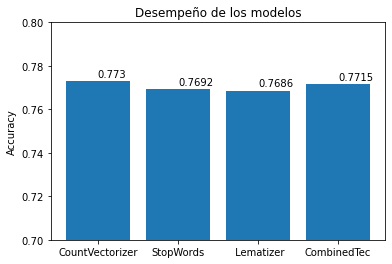

In [50]:
# Celda 5

# Se construye un DF con la información que se quiere graficar
tecnica_i = ['CountVectorizer', 'StopWords', ' Lematizer', 'CombinedTec']
accuracy_i= [accuracy_modelo_uno, accuracy_modelo_dos, accuracy_modelo_tres, accuracy_modelo_cuatro]

DF_accrc = pd.DataFrame( accuracy_i, index = tecnica_i , columns = ['Accuracy'])

# Se genera un gráfico para comparar
fig, ax = plt.subplots()

ax.set_ylabel('Accuracy')
ax.set_title('Desempeño de los modelos')
plt.ylim(0.7, 0.8)

for a,b in zip(DF_accrc.index, DF_accrc.Accuracy): 
    plt.text(a, b+0.002, str(round(b,4)))

plt.bar(x = DF_accrc.index, height = DF_accrc.Accuracy)
plt.show()



A pesar que no se percibe una diferencia significativa entre el Accuracy de los modelos construidos a partir de las 4 técnicas utilizadas, aquel que presenta mayor Accuracy es en el que se usa CountVectorizer como técnica de NLP.
Esta técnica tiene la ventaja de considerar individualmente para cada palabra, la cantidad de veces que está presente en los tuits y a partir de esto realizar las predicciones sobre qué tipo de sentimiento transmiten, de acuerdo con las características de cada vector en el set de entrenamiento, sin considerar el contexto general de la frase. 
Por otra parte la técnica de Lematización, cuenta con la capacidad de transformar cada palabra y llevarla a su lema, de modo que se asocia la información que ofrece cada una de las palabras en la frase a su significado/contexto. 